# 1. Imports
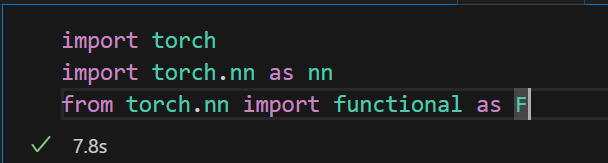

In [ ]:
# Import torch and nn

# 2. Assign Hyper Parameters

In [ ]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

# 3. Upload wizard_of_oz.txt from the repo, you are being shared

In [ ]:
# ! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()